# Unsupervised clustering using procurement documents - stats on clusters

In [1]:
import gensim
import numpy as np
import pandas as pd
from gensim.models import LdaModel
from scipy.spatial.distance import jensenshannon
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from tqdm import tqdm

tqdm.pandas()

In [2]:
cpv_labels = {
    "03": "Agricultural, farming, fishing, forestry and related products",
    "09": "Petroleum products, fuel, electricity and other sources of energy",
    "14": "Mining, basic metals and related products",
    "15": "Food, beverages, tobacco and related products",
    "16": "Agricultural machinery",
    "18": "Clothing, footwear, luggage articles and accessories",
    "19": "Leather and textile fabrics, plastic and rubber materials",
    "22": "Printed matter and related products",
    "24": "Chemical products",
    "30": "Office and computing machinery, equipment and supplies except furniture and software packages",
    "31": "Electrical machinery, apparatus, equipment and consumables; Lighting",
    "32": "Radio, television, communication, telecommunication and related equipment",
    "33": "Medical equipments, pharmaceuticals and personal care products",
    "34": "Transport equipment and auxiliary products to transportation",
    "35": "Security, fire-fighting, police and defence equipment",
    "37": "Musical instruments, sport goods, games, toys, handicraft, art materials and accessories",
    "38": "Laboratory, optical and precision equipments (excl. glasses)",
    "39": "Furniture (incl. office furniture), furnishings, domestic appliances (excl. lighting) and cleaning products",
    "41": "Collected and purified water",
    "42": "Industrial machinery",
    "43": "Machinery for mining, quarrying, construction equipment",
    "44": "Construction structures and materials; auxiliary products to construction (excepts electric apparatus)",
    "45": "Construction work",
    "48": "Software package and information systems",
    "50": "Repair and maintenance services",
    "51": "Installation services (except software)",
    "55": "Hotel, restaurant and retail trade services",
    "60": "Transport services (excl. Waste transport)",
    "63": "Supporting and auxiliary transport services; travel agencies services",
    "64": "Postal and telecommunications services",
    "65": "Public utilities",
    "66": "Financial and insurance services",
    "70": "Real estate services",
    "71": "Architectural, construction, engineering and inspection services",
    "72": "IT services: consulting, software development, Internet and support",
    "73": "Research and development services and related consultancy services",
    "75": "Administration, defence and social security services",
    "76": "Services related to the oil and gas industry",
    "77": "Agricultural, forestry, horticultural, aquacultural and apicultural services",
    "79": "Business services: law, marketing, consulting, recruitment, printing and security",
    "80": "Education and training services",
    "85": "Health and social work services",
    "90": "Sewage-, refuse-, cleaning-, and environmental services",
    "92": "Recreational, cultural and sporting services",
    "98": "Other community, social and personal services",
}

## Dataset loading

In [3]:
df = pd.read_csv("tmp/20230511-dataset-preprocessed-procurement-data-eu-notices.csv", index_col=0)
df

03     09     14     15     16     18     19     22  \
id                                                                          
2017/S 102-203726  False  False  False  False  False  False  False  False   
2014/S 138-246767  False  False  False  False  False  False  False  False   
2017/S 164-337354  False  False  False  False  False  False  False  False   
2016/S 070-121405  False  False  False  False  False  False  False  False   
2022/S 084-222910  False  False  False  False  False  False  False  False   
...                  ...    ...    ...    ...    ...    ...    ...    ...   
2020/S 106-255487  False  False  False  False  False  False  False  False   
2022/S 125-351443  False  False  False  False  False  False  False  False   
2022/S 101-278437  False  False  False  False  False  False  False  False   
2018/S 052-114411  False  False  False  False  False  False  False  False   
2019/S 118-288646  False  False  False  False  False  False  False  False   

                      24     30  ...     75     76     77     79     80  \
id                               ...                                      
2017/S 102-203726  False  False  ...  False  False  False  False  False   
2014/S 138-246767  False  False  ...  False  False  False  False   True   
2017/S 164-337354  False  False  ...  False  False  False  False   True   
2016/S 070-121405  False  False  ...  False  False  False  False  False   
2022/S 084-222910  False  False  ...  False  False  False  False  False   
...                  ...    ...  ...    ...    ...    ...    ...    ...   
2020/S 106-255487  False  False  ...  False  False  False  False  False   
2022/S 125-351443  False  False  ...  False  False  False  False  False   
2022/S 101-278437  False  False  ...  False  False  False  False  False   
2018/S 052-114411  False  False  ...  False  False  False   True  False   
2019/S 118-288646  False  False  ...  False  False  False  False  False   

                      85     90     92     98  \
id                                              
2017/S 102-203726   True  False  False  False   
2014/S 138-246767  False  False  False  False   
2017/S 164-337354  False  False  False  False   
2016/S 070-121405  False  False  False  False   
2022/S 084-222910  False  False  False  False   
...                  ...    ...    ...    ...   
2020/S 106-255487  False  False  False  False   
2022/S 125-351443  False  False  False  False   
2022/S 101-278437  False  False  False  False   
2018/S 052-114411  False  False  False  False   
2019/S 118-288646  False  False  False  False   

                                                                text  
id                                                                    
2017/S 102-203726  tender specificationsopen callreview procureme...  
2014/S 138-246767  page technical specifications lot languages pr...  
2017/S 164-337354  tender page tenders framework contract provisi...  
2016/S 070-121405  cost noncooperation page open procedure poolin...  
2022/S 084-222910  multiple framework service contract perform de...  
...                                                              ...  
2020/S 106-255487  tender open procedure purchasing allterrain ar...  
2022/S 125-351443  retieseweg fax good supply order place follow ...  
2022/S 101-278437  tender specification regional incountry suppor...  
2018/S 052-114411  assessment cost provide wholesale voice termin...  
2019/S 118-288646  framework contract lot supply small equipment ...  

[3797 rows x 46 columns]

In [4]:
df = df.dropna(subset=['text'])
df

03     09     14     15     16     18     19     22  \
id                                                                          
2017/S 102-203726  False  False  False  False  False  False  False  False   
2014/S 138-246767  False  False  False  False  False  False  False  False   
2017/S 164-337354  False  False  False  False  False  False  False  False   
2016/S 070-121405  False  False  False  False  False  False  False  False   
2022/S 084-222910  False  False  False  False  False  False  False  False   
...                  ...    ...    ...    ...    ...    ...    ...    ...   
2020/S 106-255487  False  False  False  False  False  False  False  False   
2022/S 125-351443  False  False  False  False  False  False  False  False   
2022/S 101-278437  False  False  False  False  False  False  False  False   
2018/S 052-114411  False  False  False  False  False  False  False  False   
2019/S 118-288646  False  False  False  False  False  False  False  False   

                      24     30  ...     75     76     77     79     80  \
id                               ...                                      
2017/S 102-203726  False  False  ...  False  False  False  False  False   
2014/S 138-246767  False  False  ...  False  False  False  False   True   
2017/S 164-337354  False  False  ...  False  False  False  False   True   
2016/S 070-121405  False  False  ...  False  False  False  False  False   
2022/S 084-222910  False  False  ...  False  False  False  False  False   
...                  ...    ...  ...    ...    ...    ...    ...    ...   
2020/S 106-255487  False  False  ...  False  False  False  False  False   
2022/S 125-351443  False  False  ...  False  False  False  False  False   
2022/S 101-278437  False  False  ...  False  False  False  False  False   
2018/S 052-114411  False  False  ...  False  False  False   True  False   
2019/S 118-288646  False  False  ...  False  False  False  False  False   

                      85     90     92     98  \
id                                              
2017/S 102-203726   True  False  False  False   
2014/S 138-246767  False  False  False  False   
2017/S 164-337354  False  False  False  False   
2016/S 070-121405  False  False  False  False   
2022/S 084-222910  False  False  False  False   
...                  ...    ...    ...    ...   
2020/S 106-255487  False  False  False  False   
2022/S 125-351443  False  False  False  False   
2022/S 101-278437  False  False  False  False   
2018/S 052-114411  False  False  False  False   
2019/S 118-288646  False  False  False  False   

                                                                text  
id                                                                    
2017/S 102-203726  tender specificationsopen callreview procureme...  
2014/S 138-246767  page technical specifications lot languages pr...  
2017/S 164-337354  tender page tenders framework contract provisi...  
2016/S 070-121405  cost noncooperation page open procedure poolin...  
2022/S 084-222910  multiple framework service contract perform de...  
...                                                              ...  
2020/S 106-255487  tender open procedure purchasing allterrain ar...  
2022/S 125-351443  retieseweg fax good supply order place follow ...  
2022/S 101-278437  tender specification regional incountry suppor...  
2018/S 052-114411  assessment cost provide wholesale voice termin...  
2019/S 118-288646  framework contract lot supply small equipment ...  

[3794 rows x 46 columns]

In [5]:
{c: df[c].sum() for c in cpv_labels.keys()}

{'03': 0,
 '09': 0,
 '14': 2,
 '15': 4,
 '16': 0,
 '18': 7,
 '19': 2,
 '22': 17,
 '24': 13,
 '30': 60,
 '31': 17,
 '32': 38,
 '33': 35,
 '34': 26,
 '35': 45,
 '37': 1,
 '38': 97,
 '39': 39,
 '41': 0,
 '42': 16,
 '43': 0,
 '44': 10,
 '45': 26,
 '48': 45,
 '50': 66,
 '51': 9,
 '55': 33,
 '60': 42,
 '63': 54,
 '64': 63,
 '65': 5,
 '66': 73,
 '70': 7,
 '71': 167,
 '72': 406,
 '73': 493,
 '75': 23,
 '76': 1,
 '77': 28,
 '79': 1105,
 '80': 188,
 '85': 110,
 '90': 336,
 '92': 95,
 '98': 26}

In [6]:
processed_docs = df["text"].apply(lambda x: x.split(" "))

dictionary = gensim.corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

## Best model training

Based on results in [this notebook](20230508-unsupervised-clustering-lda-procurement-docs.ipynb).

In [ ]:
lda_model = LdaModel(bow_corpus, num_topics=60, id2word=dictionary, passes=15, alpha='symmetric', eta=0.1,
                     minimum_probability=0.0, random_state=0)

In [9]:
lda_model.save("tmp/20230522-lda-60topics-15passes-alphasymmetric-eta0.1")

In [7]:
lda_model = LdaModel.load("tmp/20230522-lda-60topics-15passes-alphasymmetric-eta0.1")
for idx, topic in lda_model.print_topics(-1):
    print('-- Topic: {} --\n{}\n'.format(idx, topic))

-- Topic: 0 --
0.024*"insurance" + 0.023*"food" + 0.013*"machine" + 0.012*"catering" + 0.012*"fruit" + 0.011*"coffee" + 0.010*"gram" + 0.009*"weight" + 0.009*"fresh" + 0.008*"drink"

-- Topic: 1 --
0.099*"platform" + 0.036*"web" + 0.025*"portal" + 0.013*"functionality" + 0.011*"search" + 0.008*"host" + 0.008*"community" + 0.007*"digital" + 0.007*"infrastructure" + 0.006*"maintenance"

-- Topic: 2 --
0.018*"corruption" + 0.018*"offence" + 0.017*"abovementioned" + 0.014*"signatory" + 0.013*"supervisory" + 0.012*"debt" + 0.011*"officer" + 0.011*"attempt" + 0.011*"judicial" + 0.010*"competent"

-- Topic: 3 --
0.088*"medical" + 0.071*"health" + 0.022*"examination" + 0.014*"care" + 0.014*"test" + 0.014*"healthcare" + 0.014*"patient" + 0.011*"treatment" + 0.010*"clinical" + 0.010*"disease"

-- Topic: 4 --
0.010*"services" + 0.008*"damage" + 0.007*"tendering" + 0.007*"claim" + 0.006*"category" + 0.005*"assignment" + 0.005*"department" + 0.005*"classify" + 0.004*"audits" + 0.004*"conformity"

-

## Find best number of clusters

### Create distance matrix to prepare clustering

In [8]:
doc_topics = lda_model.get_document_topics(bow_corpus)

In [9]:
doc_probabilities = np.zeros((len(bow_corpus), lda_model.num_topics))
for doc_id, topics in tqdm(enumerate(doc_topics), total=len(doc_topics)):
    for topic, prob in topics:
        doc_probabilities[doc_id, topic] = prob

100%|██████████| 3794/3794 [00:28<00:00, 131.45it/s]


In [10]:
distance_matrix = np.zeros((len(bow_corpus), len(bow_corpus)))
for doc1_id in tqdm(range(len(bow_corpus)), total=len(bow_corpus)):
    for doc2_id in range(len(bow_corpus)):
        distance_matrix[doc1_id, doc2_id] = jensenshannon(doc_probabilities[doc1_id], doc_probabilities[doc2_id])

100%|██████████| 3794/3794 [05:12<00:00, 12.14it/s]


In [11]:
distance_matrix[np.isnan(distance_matrix)] = -1

### Perform grid search

In [107]:
def clustering_score(n_clusters: str):
    model = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
    model.fit_predict(distance_matrix)
    return silhouette_score(distance_matrix, model.labels_, metric='euclidean')

In [108]:
from pandas import DataFrame
from pandas.core.reshape.util import cartesian_product

n_clusters = list(range(10, 200, 10))

n_clusters_product, = cartesian_product([n_clusters])
results = DataFrame({'n_clusters': n_clusters_product})
results

n_clusters
0           10
1           20
2           30
3           40
4           50
5           60
6           70
7           80
8           90
9          100
10         110
11         120
12         130
13         140
14         150
15         160
16         170
17         180
18         190

In [109]:
results['silhouette_score'] = results.progress_apply(lambda x: clustering_score(x['n_clusters']), axis=1)

  0%|          | 0/19 [00:00<?, ?it/s]/home/ferreni/Projects/TED AI/Repositories/tedai-cpv-classification/venv/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
 11%|█         | 2/19 [00:14<02:05,  7.37s/it]/home/ferreni/Projects/TED AI/Repositories/tedai-cpv-classification/venv/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
 16%|█▌        | 3/19 [00:30<02:52, 10.75s/it]/home/ferreni/Projects/TED AI/Repositories/tedai-cpv-classification/venv/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation mat

In [110]:
best_n_clusters = results.iloc[results['silhouette_score'].argmax()]['n_clusters']
best_n_clusters

40.0

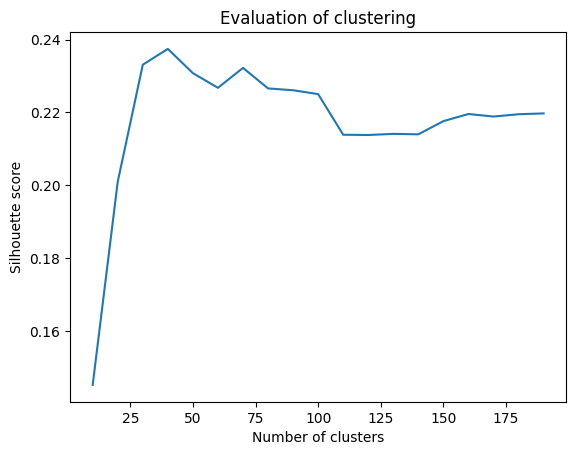

In [111]:
from matplotlib import pyplot as plt

plt.plot(results["n_clusters"], results["silhouette_score"])
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.title("Evaluation of clustering")
plt.show()

In [103]:
from pandas import DataFrame
from pandas.core.reshape.util import cartesian_product

n_clusters = list(range(25, 80))

n_clusters_product, = cartesian_product([n_clusters])
results = DataFrame({'n_clusters': n_clusters_product})
results

n_clusters
0           25
1           26
2           27
3           28
4           29
5           30
6           31
7           32
8           33
9           34
10          35
11          36
12          37
13          38
14          39
15          40
16          41
17          42
18          43
19          44
20          45
21          46
22          47
23          48
24          49
25          50
26          51
27          52
28          53
29          54
30          55
31          56
32          57
33          58
34          59
35          60
36          61
37          62
38          63
39          64
40          65
41          66
42          67
43          68
44          69
45          70
46          71
47          72
48          73
49          74
50          75
51          76
52          77
53          78
54          79

In [104]:
results['silhouette_score'] = results.progress_apply(lambda x: clustering_score(x['n_clusters']), axis=1)

  0%|          | 0/55 [00:00<?, ?it/s]/home/ferreni/Projects/TED AI/Repositories/tedai-cpv-classification/venv/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
  4%|▎         | 2/55 [00:12<05:23,  6.10s/it]/home/ferreni/Projects/TED AI/Repositories/tedai-cpv-classification/venv/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
  5%|▌         | 3/55 [00:27<08:29,  9.80s/it]/home/ferreni/Projects/TED AI/Repositories/tedai-cpv-classification/venv/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation mat

In [105]:
best_n_clusters = results.iloc[results['silhouette_score'].argmax()]['n_clusters']
best_n_clusters

32.0

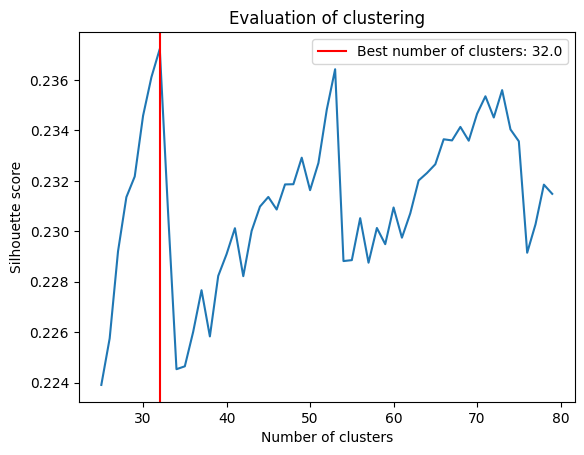

In [109]:
from matplotlib import pyplot as plt

plt.plot(results["n_clusters"], results["silhouette_score"])
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.title("Evaluation of clustering")
plt.axvline(x=best_n_clusters, color='r', label=f'Best number of clusters: {best_n_clusters}')
plt.legend(loc=0)
plt.show()

## Cluster Study

In [99]:
n_clusters = 32
clustering_model = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
clusters = clustering_model.fit_predict(distance_matrix)

/home/ferreni/Projects/TED AI/Repositories/tedai-cpv-classification/venv/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/home/ferreni/Projects/TED AI/Repositories/tedai-cpv-classification/venv/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [13]:
cluster_cpvs = []
for doc_id, cluster_id in tqdm(enumerate(clusters), total=len(clusters)):
    for _ in range(len(cluster_cpvs), cluster_id + 1):
        cluster_cpvs.append([])
    doc = df.iloc[doc_id]
    cluster_cpvs[cluster_id].append([c for c in df.columns if len(c) == 2 and doc[c]])

100%|██████████| 3794/3794 [00:00<00:00, 7073.62it/s]


### Notice repartition among clusters

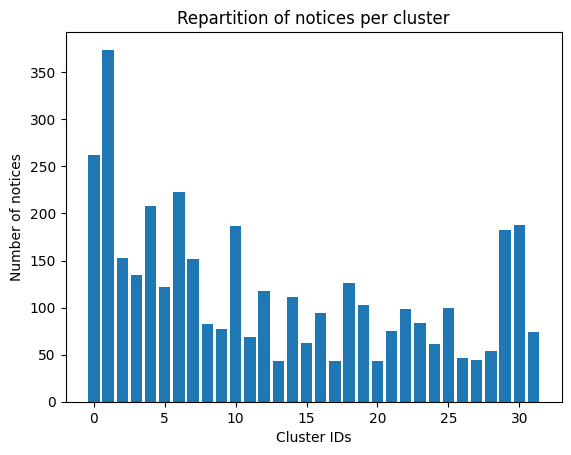

In [14]:
from matplotlib import pyplot as plt

plt.bar(range(len(cluster_cpvs)), [len(t) for t in cluster_cpvs])
plt.xlabel("Cluster IDs")
plt.ylabel("Number of notices")
plt.title("Repartition of notices per cluster")
plt.show()

### CPV repartition per cluster

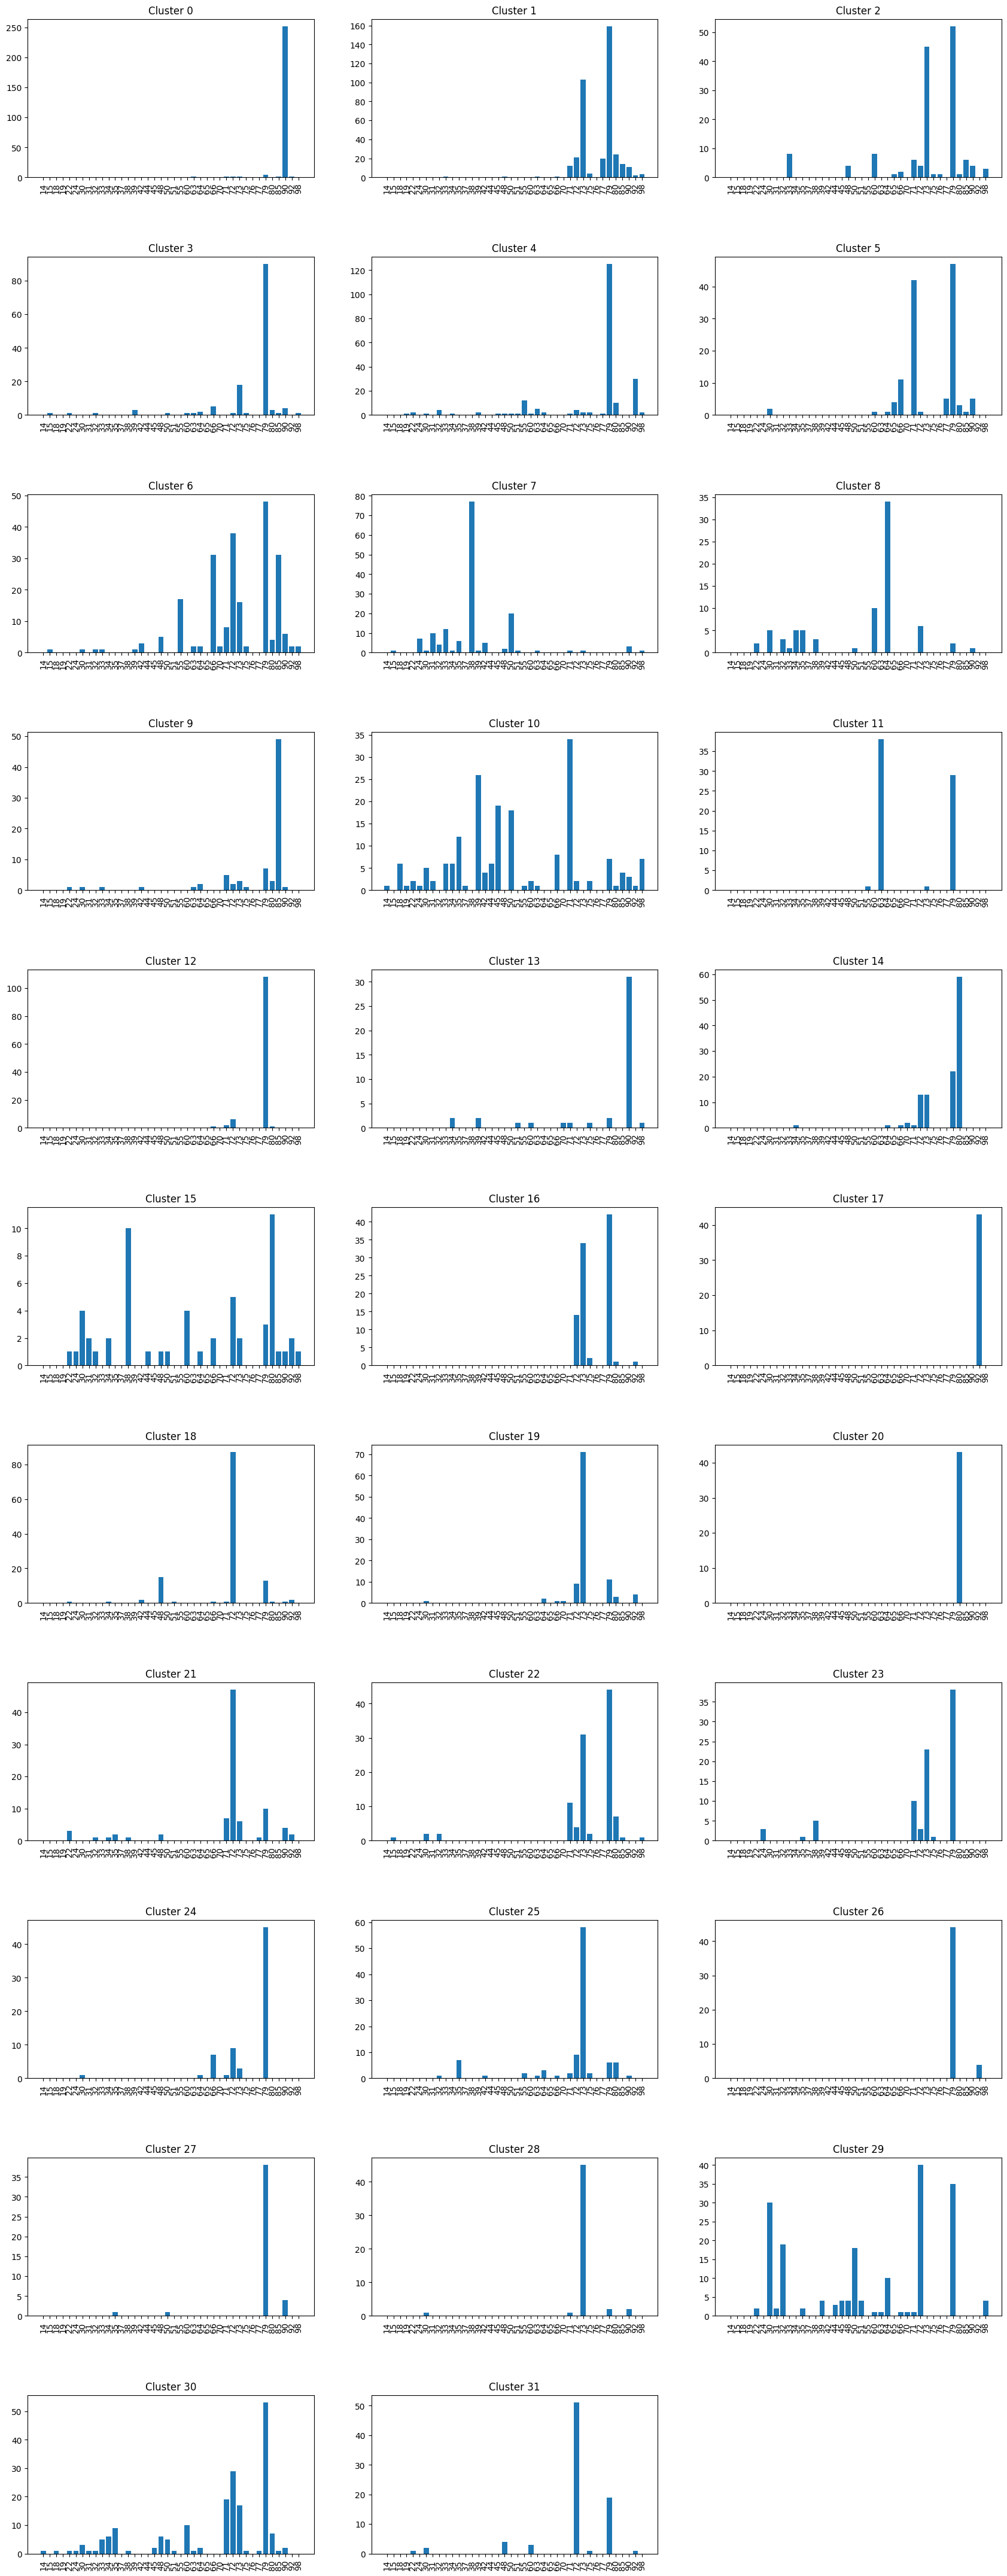

In [100]:
import math
from matplotlib.gridspec import GridSpec

cluster_count = len(cluster_cpvs)
width_figure_count = 3
height_figure_count = math.ceil(cluster_count / width_figure_count)

cpvs = [c for c in cpv_labels.keys() if df[c].sum() > 0]

# Number of notices per CPV for each cluster
gs = GridSpec(height_figure_count, width_figure_count)
plt.figure(figsize=(width_figure_count * 7, height_figure_count * 5))
plt.subplots_adjust(hspace=0.5)
for cluster_id in range(cluster_count):
    cpv_counts = [sum(p.count(c) for p in cluster_cpvs[cluster_id]) for c in cpvs]
    plt.subplot(gs[int(cluster_id / width_figure_count), int(cluster_id % width_figure_count)])
    plt.bar(cpvs, cpv_counts)
    plt.xticks(rotation=90)
    plt.title(f"Cluster {cluster_id}")
plt.show()

### Cluster repartition per CPV

In [105]:
cpv_clusters = {c: [] for c in cpv_labels.keys() if df[c].sum() > 0}
for doc_id, cluster_id in tqdm(enumerate(clusters), total=len(clusters)):
    doc = df.iloc[doc_id]
    cpvs = [c for c in df.columns if len(c) == 2 and doc[c]]
    for cpv in cpvs:
        cpv_clusters[cpv].append(cluster_id)

100%|██████████| 3794/3794 [00:00<00:00, 8224.81it/s]


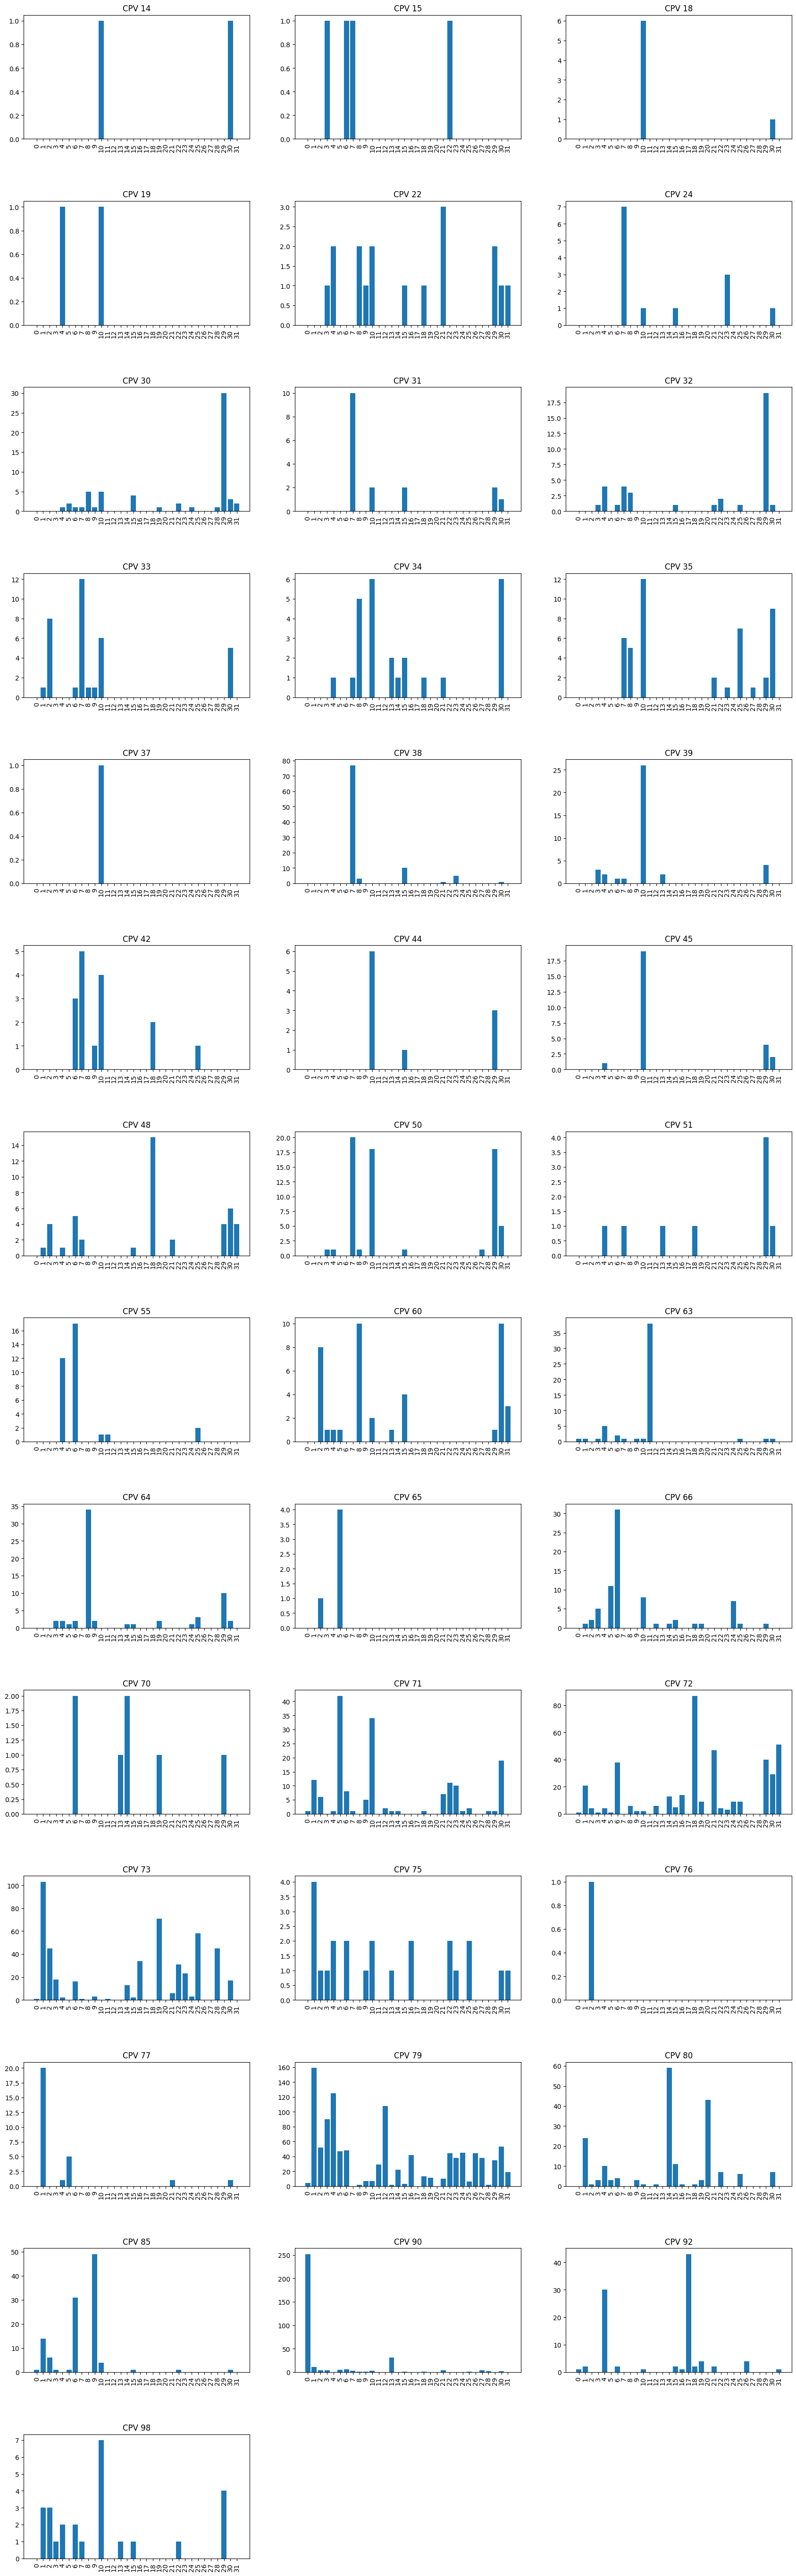

In [106]:
import math
from matplotlib.gridspec import GridSpec

cpv_count = len(cpv_clusters)
width_figure_count = 3
height_figure_count = math.ceil(cpv_count / width_figure_count)

cluster_ids = list(range(cluster_count))

# Number of notices per cluster for each CPV
gs = GridSpec(height_figure_count, width_figure_count)
plt.figure(figsize=(width_figure_count * 7, height_figure_count * 5))
plt.subplots_adjust(hspace=0.5)
for cpv_id, cpv in enumerate(cpv_clusters.keys()):
    cluster_counts = [cpv_clusters[cpv].count(c) for c in cluster_ids]
    plt.subplot(gs[int(cpv_id / width_figure_count), int(cpv_id % width_figure_count)])
    plt.bar(cluster_ids, cluster_counts)
    plt.xticks(cluster_ids, rotation=90)
    plt.title(f"CPV {cpv}")
plt.show()